# **CFDPyRun**

This notebook consists of my run-through of Prof. Lorena Barba's "12 steps to Navier-Stokes" course, because I admit I have a problem with fluids. It is set in a "professor first, student next" fashion, with the student developing the stock functions with his/her own ideas. The development is chronologically presented.

#### Python libraries

In [626]:
import numpy
import sympy
from sympy import init_printing
from sympy.utilities.lambdify import lambdify
import time, sys
from matplotlib import rc, pyplot, cm
from sympy import init_printing
from mpl_toolkits.mplot3d import Axes3D
init_printing(use_latex=True)
rc('font',**{'family':'serif'})
rc('text', usetex=True)

### **Step 1: 1-D Linear Convection**

#### Professor

Partial differential equation: $$ \frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0 $$

Discretised: $$ \frac{u^{n+1}_i - u^n_i}{\Delta t} + c\frac{u^n_i - u^n_{i-1}}{\Delta x} = 0 $$

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


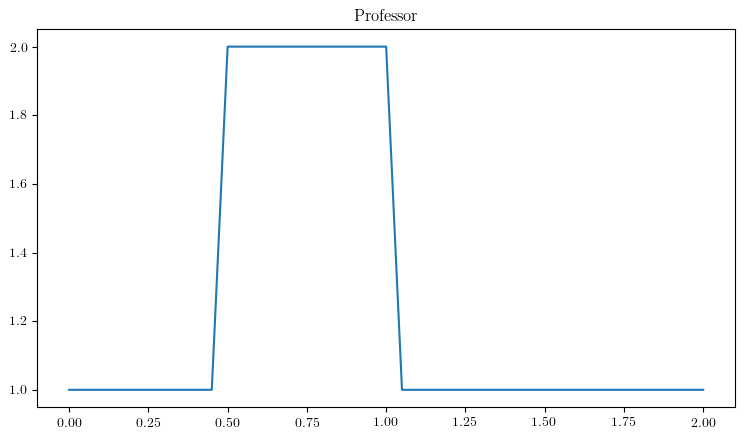

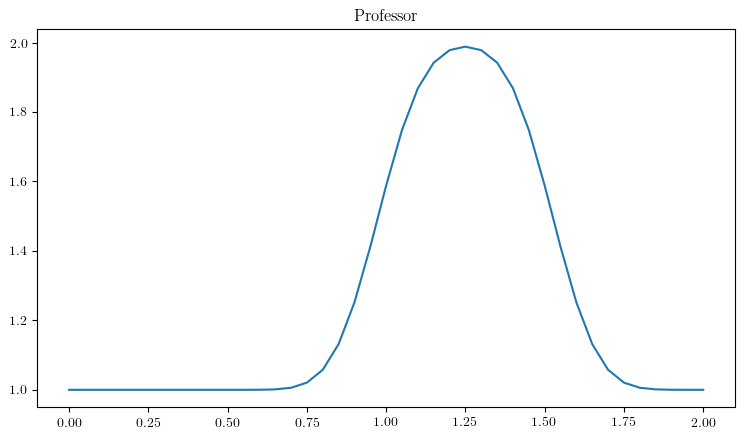

In [645]:
nx = 41
dx = 2.0/(nx-1)
nt = 20
dt = 0.025
c = 1.0

u = numpy.ones(nx)
u[int (.5/dx): int(1/dx + 1)] = 2.0
print(u)

pyplot.figure(1, figsize=(9,5), dpi=100)
pyplot.title('Professor')
pyplot.plot(numpy.linspace(0,2,nx), u)

for n in range(nt):
    un = u.copy()
    for i in range(1,nx):
        u[i] = un[i] - c*dt/dx*(un[i] - un[i-1])

pyplot.figure(2, figsize=(9,5), dpi=100)
pyplot.title('Professor')
pyplot.plot(numpy.linspace(0,2,nx), u)
pyplot.show()

#### Student

No time to lose. (Down with mutability!)

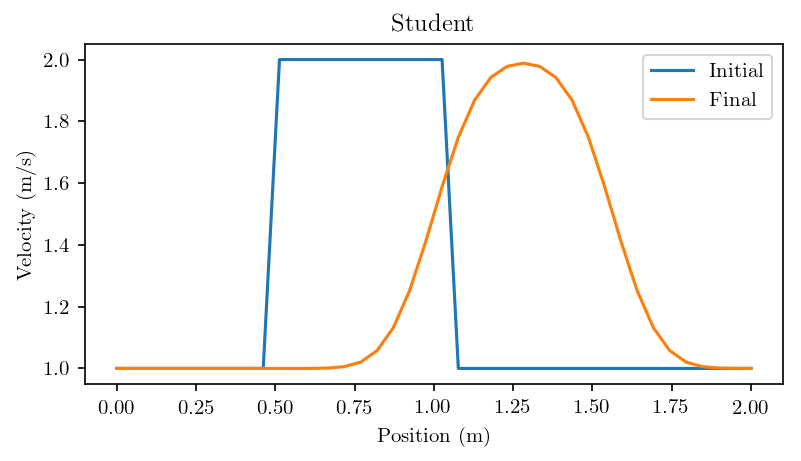

In [646]:
def linearConvection(nx):
    dx = 2.0/nx
    nt = 21
    dt = 0.025
    c = 1
    
    x = numpy.linspace(0,2,nx)
    u = numpy.ones((nt,nx))
    u[0][int (.5/dx): int(1/dx +1)] = 2.0

    for n in range(nt-1):
        for i in range(1,nx):
            u[n+1][i] = u[n][i] - c*dt/dx*(u[n][i] - u[n][i-1])
    
    pyplot.figure(1,figsize=(6,3), dpi=150)
    pyplot.title('Student')
    pyplot.plot(x, u[0], label='Initial')
    pyplot.plot(x, u[nt-1], label='Final')
    pyplot.xlabel('Position (m)')
    pyplot.ylabel('Velocity (m/s)')
    pyplot.legend()

linearConvection(40)

### **Step 2: 1-D Nonlinear Convection**

#### Professor

Partial differential equation: $$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = 0 $$

Discretised: $$ \frac{u^{n+1}_i - u^n_i}{\Delta t} + u^n_i\frac{u^n_i - u^n_{i-1}}{\Delta x} = 0 $$

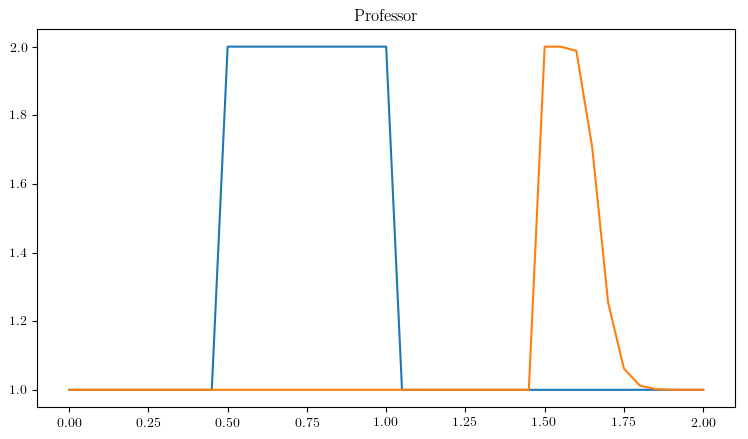

In [647]:
nx = 41
dx = 2.0/(nx-1)
nt = 20
dt = 0.025

u = numpy.ones(nx)
u[int (.5/dx): int(1/dx + 1)] = 2.0

pyplot.figure(figsize=(9,5), dpi=100)
pyplot.title('Professor')
pyplot.plot(numpy.linspace(0,2,nx), u)

for n in range(nt):
    un = u.copy()
    for i in range(1,nx):
        u[i] = un[i]*(1 - dt/dx*(un[i] - un[i-1]))

pyplot.plot(numpy.linspace(0,2,nx), u)
pyplot.show()

#### Student

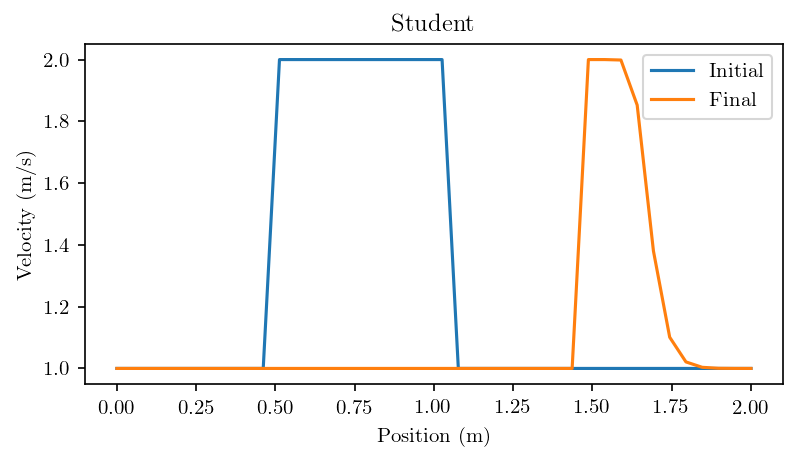

In [648]:
def nonLinearConvection(nx):
    dx = 2.0/nx
    nt = 20
    dt = 0.025
    
    x = numpy.linspace(0,2,nx)
    u = numpy.ones((nt,nx))
    u[0][int (.5/dx): int(1/dx + 1)] = 2.0

    for n in range(nt-1):
        for i in range(1,nx):
            u[n+1][i] = u[n][i]*(1 - dt/dx*(u[n][i] - u[n][i-1]))
            
    return x, u

pos, vel = nonLinearConvection(40)

# Plotting
pyplot.figure(1,figsize=(6,3), dpi=150)
pyplot.title('Student')
pyplot.plot(pos, vel[0], label='Initial')
pyplot.plot(pos, vel[-1], label='Final')
pyplot.xlabel('Position (m)')
pyplot.ylabel('Velocity (m/s)')
pyplot.legend()
pyplot.show()

### **Investigation: CFL Condition**

#### Professor

Courant number: $$ \sigma = \frac{u\Delta t}{\Delta x} \leq \sigma_{\max} $$

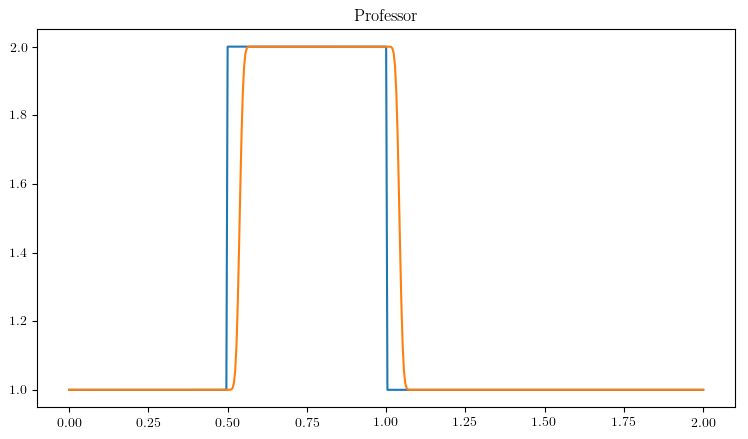

In [649]:
def linearconv(nx):
    dx = 2.0/(nx-1)
    nt = 20
    c = 1.0
    sigma = 0.5
    dt = sigma*dx
    
    u = numpy.ones(nx)
    u[int (.5/dx): int(1/dx + 1)] = 2.0

    pyplot.figure(1, figsize=(9,5), dpi=100)
    pyplot.title('Professor')
    pyplot.plot(numpy.linspace(0,2,nx), u)

    for n in range(nt):
        un = u.copy()
        for i in range(1,nx):
            u[i] = un[i] - c*dt/dx*(un[i] - un[i-1])

    pyplot.plot(numpy.linspace(0,2,nx), u)

linearconv(501)

#### Student

This function allows you to input the simulation time and time-step size and provides warnings if the Courant Number is greater than 1 with recommendations.

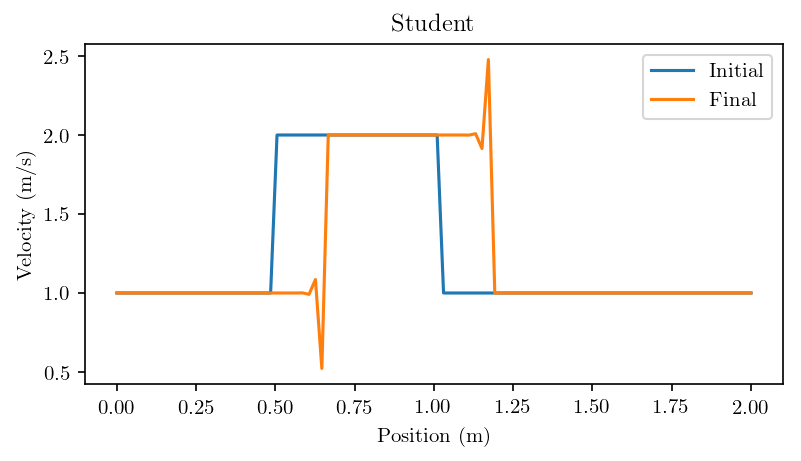

In [650]:
def linearConvectionCFL(mesh_size, time, dt):
    dx = 2.0/mesh_size
    c = 1
    time_steps = int(time/dt)
    sigma_max = dt/dx
    if sigma_max > 1:
        correct_dt = dx
        print('Warning: CFL Number greater than 1. Solver will probably produce incorrect results. Maximum time-step should be %s.' %correct_dt)
    
    # Initial condition definition
    x = numpy.linspace(0,2,mesh_size)
    u = numpy.ones((time_steps,mesh_size))
    u[0][int (.5/dx): int(1/dx + 1)] = 2.0

    for n in range(time_steps-1):
        for i in range(1,mesh_size):
            u[n+1][i] = u[n][i] - c*dt/dx*(u[n][i] - u[n][i-1])
            
    return x, u
    
pos, vel = linearConvectionCFL(100, 0.2, 0.021)

# Plotting
pyplot.figure(1,figsize=(6,3), dpi=150)
pyplot.title('Student')
pyplot.plot(pos, vel[0], label='Initial')
pyplot.plot(pos, vel[-1], label='Final')
pyplot.xlabel('Position (m)')
pyplot.ylabel('Velocity (m/s)')
pyplot.legend()
pyplot.show()

### **Step 3: Diffusion Equation in 1-D**

#### Professor

Partial differential equation: $$ \frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2} $$

Discretised: $$ \frac{u^{n+1}_i - u^n_i}{\Delta t} = \nu\frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{(\Delta x)^2} $$

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


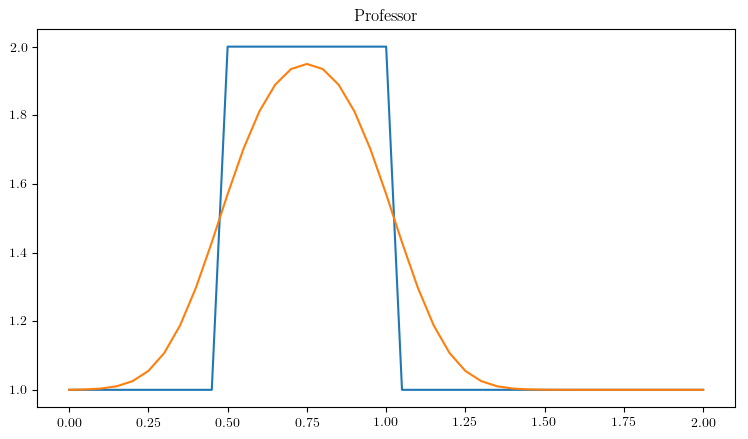

In [652]:
nx = 41
dx = 2.0/(nx-1)
nt = 20
nu = 0.3
sigma = 0.2
dt = sigma*dx**2/nu

u = numpy.ones(nx)
u[int (.5/dx): int(1/dx + 1)] = 2.0
print(u)

pyplot.figure(1, figsize=(9,5), dpi=100)
pyplot.title('Professor')
pyplot.plot(numpy.linspace(0,2,nx), u)

for n in range(nt):
    un = u.copy()
    for i in range(1,nx - 1):
        u[i] = un[i] + nu*dt/dx**2*(un[i+1] - 2*un[i] + un[i-1] )

pyplot.plot(numpy.linspace(0,2,nx), u)
pyplot.show()

#### Student

This version forces the Courant Number to be 0.2 and calculates the time-step based on the mesh size accordingly for "accurate" results. It also takes user input of simulation time.

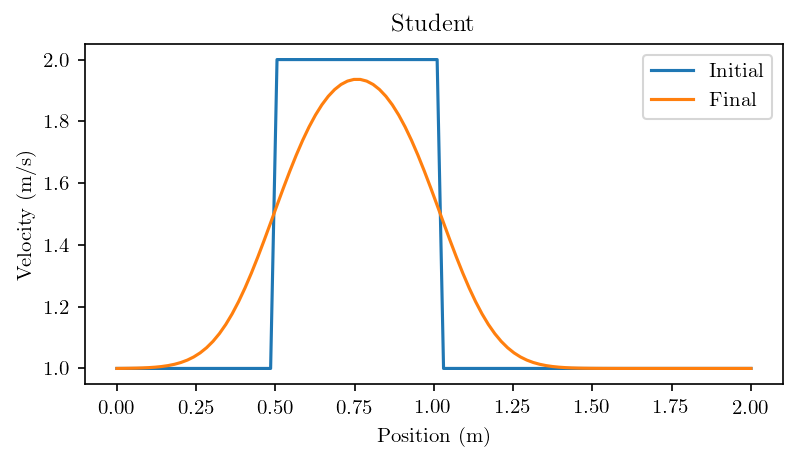

In [653]:
def diffusionEquation(mesh_size, time):
    dx = 2.0/mesh_size
    nu = 0.3
    sigma_max = 0.2
    dt = sigma_max*dx**2/nu
    time_steps = int(time/dt)
    
    ## Initial condition definition
    x = numpy.linspace(0,2,mesh_size)
    u = numpy.ones((time_steps,mesh_size))
    u[0][int (.5/dx): int(1/dx + 1)] = 2.0

    for n in range(time_steps-1):
        for i in range(1,mesh_size - 1):
            u[n+1][i] = u[n][i] + nu*dt/dx**2*(u[n][i+1] - 2*u[n][i] + u[n][i-1])
    
    return x, u

pos, vel = diffusionEquation(100, 0.0333333)

# Plotting
pyplot.figure(1,figsize=(6,3), dpi=150)
pyplot.title('Student')
pyplot.plot(pos, vel[0], label='Initial')
pyplot.plot(pos, vel[-1], label='Final')
pyplot.xlabel('Position (m)')
pyplot.ylabel('Velocity (m/s)')
pyplot.legend()
pyplot.show()


### **Step 4: Burgers' Equation**

### Professor

Partial differential equation: 

$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu\frac{\partial^2 u}{\partial x^2} $$

Discretised: $$ \frac{u^{n+1}_i - u^n_i}{\Delta t} + u^n_i\frac{u^n_i - u^n_{i-1}}{\Delta x} = \nu\frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{(\Delta x)^2} $$

Initial conditions (using the analytical solution): 

$$ u(x,0) = -\frac{2\nu}{\phi}\frac{\partial\phi}{\partial x} + 4 $$

$$ \phi(x,0) = \exp\left(\frac{-x^2}{4\nu}\right) + \exp\left(\frac{-(x-2\pi)^2}{4\nu}\right) $$

Boundary condition: $$ u(0,t) = u(2\pi,t) $$

In [635]:
## Analytical solution setup using SymPy
x, t, nu = sympy.symbols('x t nu')
phi = sympy.exp(-(x-4*t)**2/(4*nu*(t+1))) + sympy.exp(-(x-4*t-2*numpy.pi)**2/(4*nu*(t+1)))
diffphi = sympy.diff(phi, x)
u = -2*nu/phi*diffphi + 4
ufunc = sympy.lambdify((t,x,nu), u)

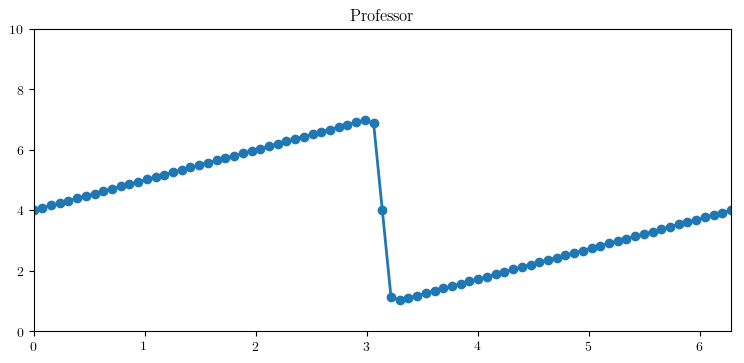

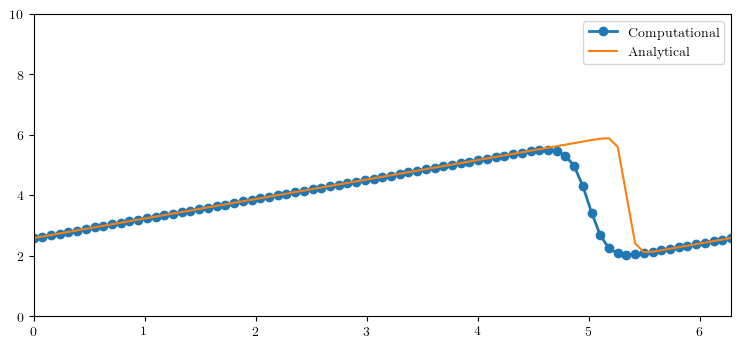

In [656]:
nx = 81
dx = 2.0*numpy.pi/(nx-1)
nt = 100
nu = 0.07
dt = dx*nu

x = numpy.linspace(0, 2*numpy.pi,nx)
un = numpy.empty(nx)
t = 0

u = numpy.asarray([ufunc(t,x0,nu) for x0 in x])

pyplot.figure(figsize=(9, 4),dpi=100)
pyplot.title('Professor')
pyplot.plot(x, u, marker='o', lw=2)
pyplot.xlim([0, 2 * numpy.pi])
pyplot.ylim([0, 10])

for n in range(nt):
    un = u.copy()
    for i in range(1,nx-1):
        u[i] = un[i]*(1-dt/dx*(un[i] - un[i-1])) + nu*dt/dx**2*(un[i+1] - 2*un[i] + un[i-1])
    u[0] = un[0]*(1-dt/dx*(un[0] - un[-2])) + nu*dt/dx**2*(un[1] - 2*un[0] + un[-2])
    u[-1] = u[0]

u_analytical = numpy.asarray([ufunc(nt*dt, xi, nu) for xi in x])

# Plotting
pyplot.figure(figsize=(9, 4),dpi=100)
pyplot.plot(x, u, marker='o', lw=2, label='Computational')
pyplot.plot(x, u_analytical, label='Analytical')
pyplot.xlim([0, 2 * numpy.pi])
pyplot.ylim([0, 10])
pyplot.legend()
pyplot.show()

#### Student

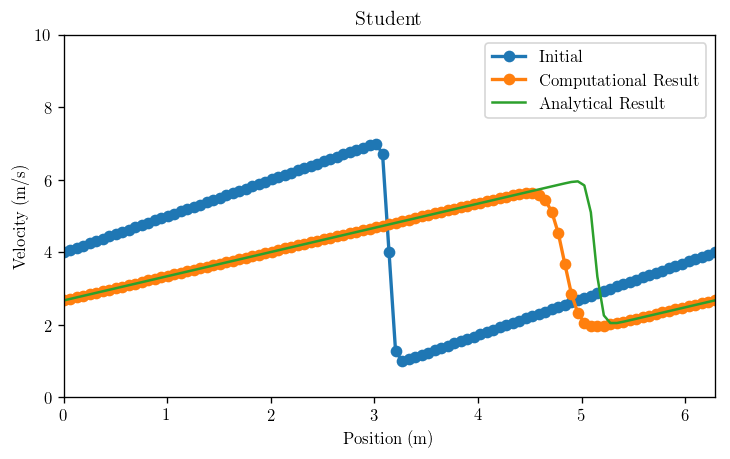

In [657]:
def burgersEquation(mesh_size, time):
    dx = 2.0*numpy.pi/(mesh_size-1)
    nu = 0.07
    dt = dx*nu
    timesteps = int(time/dt)
    
    x = numpy.linspace(0, 2*numpy.pi, mesh_size)
    u = numpy.empty((timesteps,mesh_size))
    u_analytical = numpy.asarray([ufunc(timesteps*dt, xi, nu) for xi in x])
    
    u[0] = numpy.asarray([ufunc(0,x0,nu) for x0 in x])
    
    for n in range(timesteps-1):
        for i in range(1,mesh_size-1):
            u[n+1][i] = u[n][i]*(1-dt/dx*(u[n][i] - u[n][i-1])) + nu*dt/dx**2*(u[n][i+1] - 2*u[n][i] + u[n][i-1]) 
            u[n+1][0] = u[n][0]*(1-dt/dx*(u[n][0] - u[n][-2])) + nu*dt/dx**2*(u[n][1] - 2*u[n][0] + u[n][-2])
            u[n+1][-1] = u[n+1][0]
    
    return x, u, u_analytical

pos, vel, vel_analytical = burgersEquation(101,0.5)

# Plotting
pyplot.figure(1,figsize=(7,4), dpi=120)
pyplot.title('Student')
pyplot.plot(pos, vel[0], marker='o', lw=2, label = 'Initial')
pyplot.plot(pos, vel[-1], marker='o', lw=2, label='Computational Result')
pyplot.plot(pos, vel_analytical, label='Analytical Result')
pyplot.xlabel('Position (m)')
pyplot.ylabel('Velocity (m/s)')
pyplot.xlim([0, 2*numpy.pi])
pyplot.ylim([0, 10])
pyplot.legend()
pyplot.show()

### **Aside: Kardar–Parisi–Zhang equation**

#### Student

The KPZ equation is a generalisation of Burgers' equation to multiple dimensions. Write Burgers' equation in the form:

$$ \frac{\partial u}{\partial t} + \frac{1}{2}\frac{\partial u^2}{\partial x} = \nu\frac{\partial^2 u}{\partial x^2} $$

Let $ u = \psi_x $, then Burgers' equation becomes:

$$ \psi_{tx} + \psi_x\psi_{xx} = \nu\psi_{xxx} $$

$$ \partial_x\left(\psi_t + \frac{\psi_x^2}{2} \right) = \nu\partial_x(\psi_{xx}) $$ 

Integrating with respect to x gives the following equation:

$$ \frac{\partial \psi}{\partial t} + \frac{1}{2}\left(\frac{\partial \psi}{\partial x}\right)^2 = \nu\frac{\partial^2 \psi}{\partial x^2} $$

This is the KPZ equation in one dimension, which seemingly generalises to:

$$ \frac{\partial \psi}{\partial t} + \frac{\lambda}{2}\left(\nabla \psi\right)^2 = \nu\nabla^2 \psi $$

Whatever "$(\nabla \psi)^2$" means. Let $\lambda = 2$ and take the one-dimensional case, then the equation has an integrating factor (thanks to Vyn from freenode's `##math`!), which allows it to be written in the form of the 1-D diffusion equation:

$$ \frac{\partial}{\partial t}\left[\exp\left(-\frac{\psi}{\nu}\right)\right] = \nu\frac{\partial^2}{\partial x^2}\left[\exp\left(-\frac{\psi}{\nu}\right)\right] $$ 

TODO: Add solution.

### **Step 5: 2-D Linear Convection**

#### Professor

Partial differential equation: $$ \frac{\partial u}{\partial t} + c\left(\frac{\partial u}{\partial x} + \frac{\partial u}{\partial y} \right) = 0 $$

Discretised: $$ \frac{u^{n+1}_{i,j} - u^n_{i,j}}{\Delta t} + c\left(\frac{u^n_{i,j} - u^n_{i-1,j}}{\Delta x} + \frac{u^n_{i,j} - u^n_{i,j-1}}{\Delta y}\right) = 0 $$`

__Student's modification:__ This has been modified into a function to take one input with two options, a "fast" (which uses array operations with NumPy) and a "slow" (which uses `for` loops). For fast, input `1` into the function, otherwise input any other number for slow. `timeit` has been imported to clock the processing speeds of each variant.

Array operations took 0.009673238993855193 seconds
For loops took 3.21629207697697 seconds


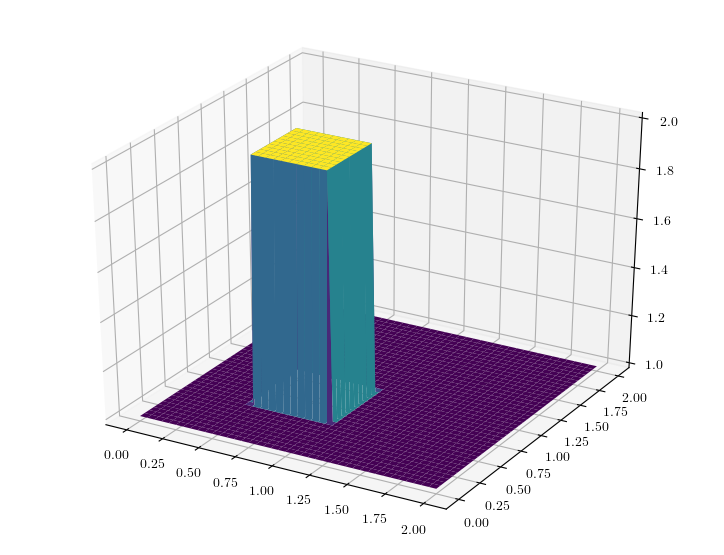

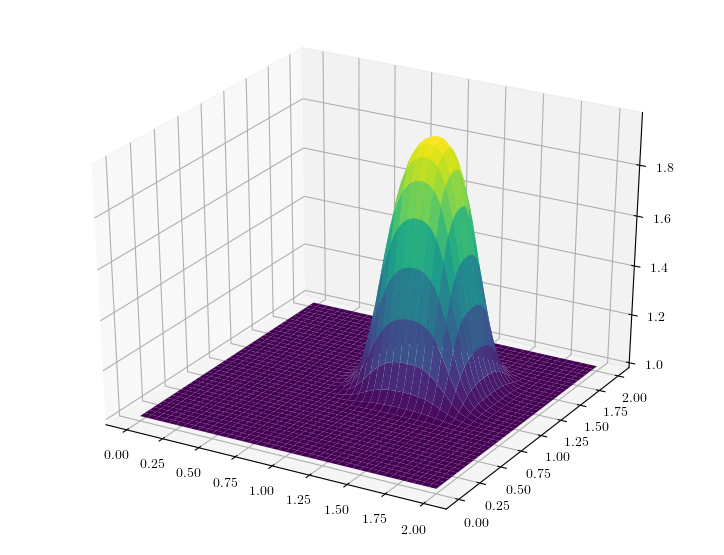

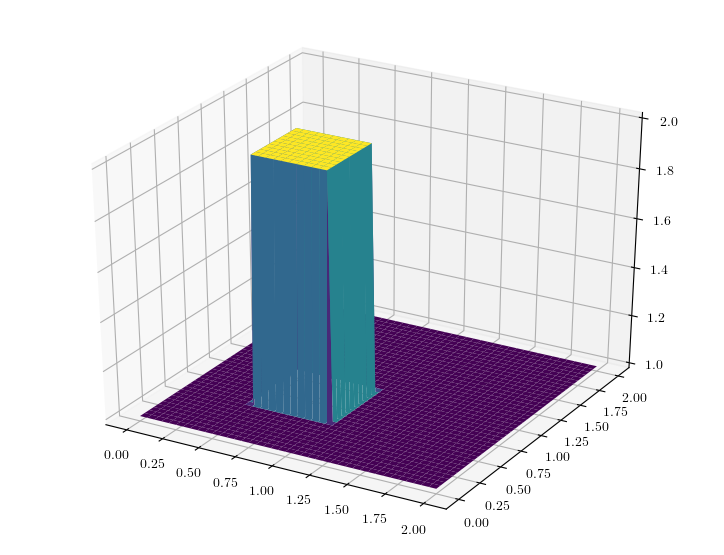

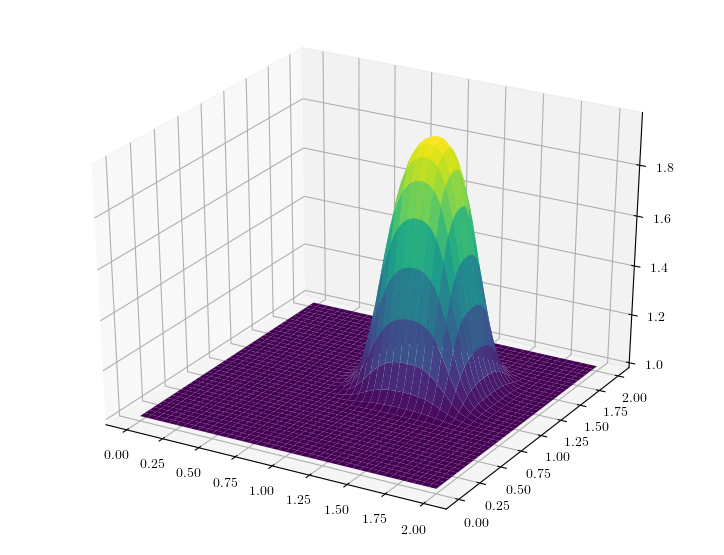

In [658]:
import timeit

def linearconv2D(speed):
    nx = 81
    ny = 81
    dx = 2.0/(nx - 1)
    dy = 2.0/(ny - 1)
    c = 1
    sigma = 0.2
    nt = 100
    dt = sigma*dx
    x = numpy.linspace(0, 2, nx)
    y = numpy.linspace(0, 2, ny)
    
    u = numpy.ones((ny,nx))
    un = numpy.ones((ny,nx))
    u[int(0.5/dy):int(1.0/dy + 1),int(.5/dx):int(1.0/dx + 1)] = 2 
    
    fig = pyplot.figure(figsize=(9,7),dpi=100)
    ax = fig.gca(projection='3d')
    X, Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)
    
    if speed == 1:
        tick = timeit.default_timer()
        for n in range(nt + 1):
            un = u.copy()
            u[1:,1:] = u[1:,1:] - c*dt*((u[1:,1:] - u[:-1,1:])/dx + (u[1:,1:] - u[1:,:-1])/dy)
            u[0,:] = 1
            u[-1,:] = 1
            u[:,0] = 1
            u[:,-1] = 1
        tock = timeit.default_timer()
        print('Array operations took %s seconds' %(tock - tick))
    else:
        tick = timeit.default_timer()
        for n in range(nt + 1):
            un = u.copy()
            row, col = u.shape
            for j in range(1, row):
                for i in range(1, col):
                    u[j,i] = un[j,i] - c*dt*((un[j,i] - un[j,i-1])/dx + (un[j,i] - un[j-1,i])/dy)
                    u[0,:] = 1
                    u[-1,:] = 1
                    u[:,0] = 1
                    u[:,-1] = 1
        tock = timeit.default_timer()
        print('For loops took %s seconds' %(tock - tick))
        
    fig = pyplot.figure(figsize=(9, 7), dpi=100)
    ax = fig.gca(projection='3d')
    surf2 = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)
    
linearconv2D(1)
linearconv2D(0)

#### Student

This function takes the mesh size in each direction as separate inputs and also the required simulation time. It minimises the time-step based on the smaller grid distance between `x` and `y` for accuracy (at the cost of speed!).

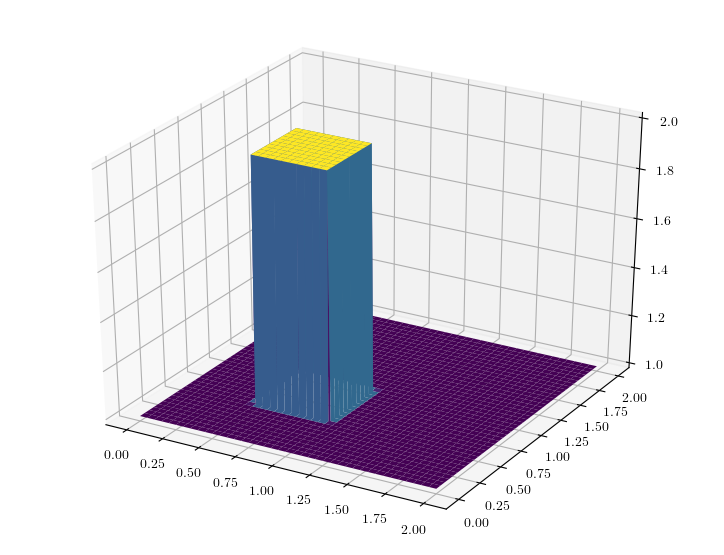

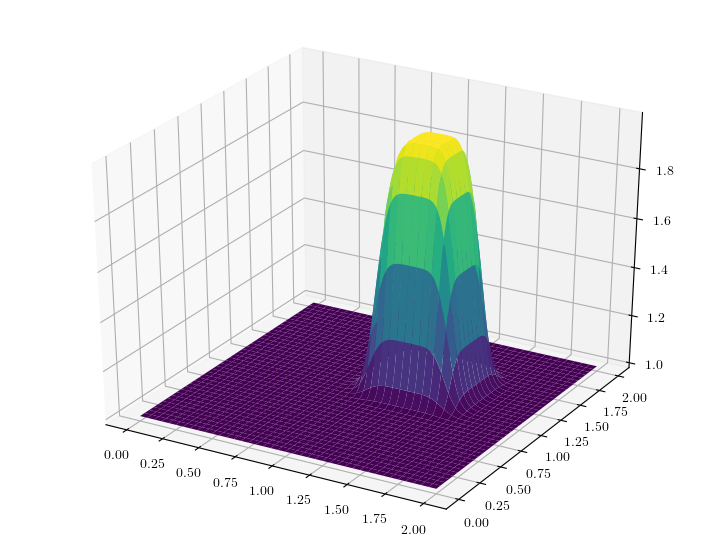

In [639]:
def linearConvection2D(mesh_size_x, mesh_size_y, time):
    dx = 2/(mesh_size_x - 1)
    dy = 2/(mesh_size_y - 1)
    c = 1
    sigma = 0.2
    dt = sigma*min(dx,dy)
    timesteps = int(time/dt)
    
    x = numpy.linspace(0,2, mesh_size_x)
    y = numpy.linspace(0,2, mesh_size_y)
    
    u = numpy.ones((timesteps, mesh_size_x, mesh_size_y))
    u[0][int(0.5/dy):int(1.0/dy + 1),int(.5/dx):int(1.0/dx + 1)] = 2
    
    for n in range(timesteps-1):
        u[n+1][1:,1:] = u[n][1:,1:] - c*dt*((u[n][1:,1:] - u[n][:-1,1:])/dx + (u[n][1:,1:] - u[n][1:,:-1])/dy)
        u[n+1][0,:] = 1
        u[n+1][-1,:] = 1
        u[n+1][:,0] = 1
        u[n+1][:,-1] = 1
        
    return x, y, u
    
pos_x, pos_y, vel = linearConvection2D(201, 201, 2.5/5.0)

# Plotting
fig = pyplot.figure(1, figsize=(9,7), dpi=100)
ax = fig.gca(projection='3d')
X, Y = numpy.meshgrid(pos_x, pos_y)
surf = ax.plot_surface(X, Y, vel[0], cmap=cm.viridis)

fig2 = pyplot.figure(2, figsize=(9,7), dpi=100)
ax = fig2.gca(projection='3d')
X, Y = numpy.meshgrid(pos_x, pos_y)
surf2 = ax.plot_surface(X, Y, vel[-1], cmap=cm.viridis)
pyplot.show()

### **Step 6: 2-D Convection**

#### Professor

Coupled partial differential equations:

$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y}  = 0 $$

$$ \frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y}  = 0 $$

Discretised:

$$ \frac{u^{n+1}_{i,j} - u^n_{i,j}}{\Delta t} + u^n_{i,j}\left(\frac{u^n_{i,j} - u^n_{i-1,j}}{\Delta x}\right) + v^n_{i,j}\left(\frac{u^n_{i,j} - u^n_{i,j-1}}{\Delta y}\right) = 0 $$

$$ \frac{v^{n+1}_{i,j} - v^n_{i,j}}{\Delta t} + u^n_{i,j}\left(\frac{v^n_{i,j} - v^n_{i-1,j}}{\Delta x}\right) + v^n_{i,j}\left(\frac{v^n_{i,j} - v^n_{i,j-1}}{\Delta y}\right) = 0 $$

Initial conditions:

$$ u, v = \begin{cases} 2, & \mathrm{for}\; x,y \in [0.5,1] \times [0.5,1] \\ 1, & \mathrm{everywhere\;else} \end{cases}$$

Boundary conditions:

$$ u = 1, v = 1 \;\mathrm{for} \begin{cases} x = 0,2 \\ y = 0,2 \end{cases} $$


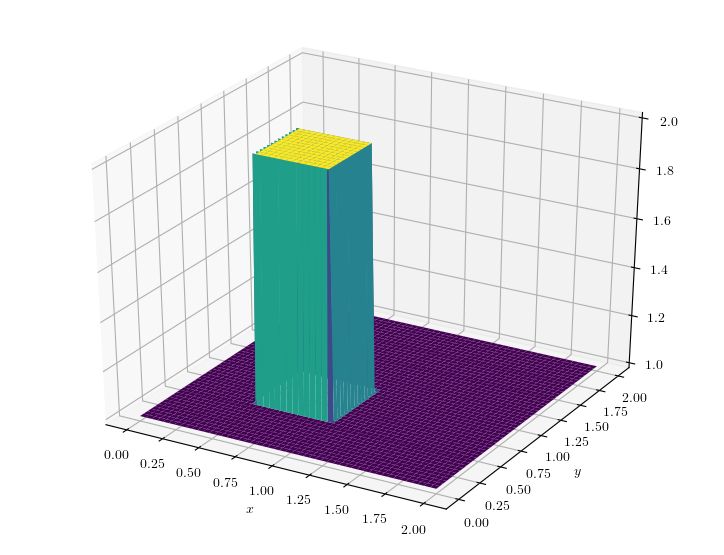

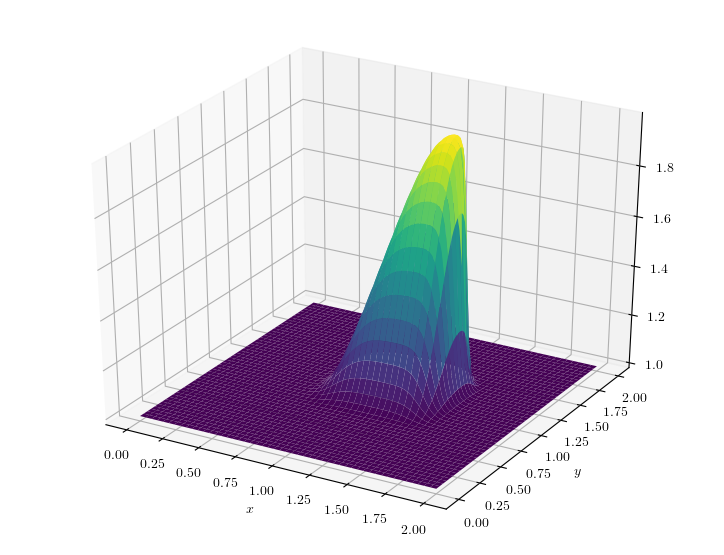

In [640]:
nx = 101
ny = 101
nt = 80
c = 1
dx = 2.0/(nx-1)
dy = 2.0/(ny-1)
sigma = 0.2
dt = sigma*dx

x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)

u = numpy.ones((ny, nx))
v = numpy.ones((ny, nx))
un = numpy.ones((ny, nx))
vn = numpy.ones((ny, nx))

u[int(.5/dy):int(1/dy + 1),int(.5/dx):int(1/dx+1)] = 2
v[int(.5/dy):int(1/dy + 1),int(.5/dx):int(1/dx+1)] = 2

fig = pyplot.figure(figsize=(9,7), dpi=100)
ax = fig.gca(projection='3d')
X, Y = numpy.meshgrid(x, y)

ax.plot_surface(X, Y, u, cmap=cm.viridis, rstride=2, cstride=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

for n in range(nt + 1):
    un = u.copy()
    vn = v.copy()
    u[1:, 1:] = un[1:, 1:] - un[1:, 1:] * c * dt / dx * (un[1:, 1:] - un[1:, :-1]) - vn[1:, 1:] * c * dt / dy * (un[1:, 1:] - un[:-1, 1:])
    v[1:, 1:] = vn[1:, 1:] - un[1:, 1:] * c * dt / dx * (vn[1:, 1:] - vn[1:, :-1]) - vn[1:, 1:] * c * dt / dy * (vn[1:, 1:] - vn[:-1, 1:])
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1
    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1

fig = pyplot.figure(figsize=(9, 7), dpi=100)
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, u, cmap=cm.viridis, rstride=2, cstride=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
pyplot.show()

#### Student

These PDEs can be written concisely in tensor notation using Einstein's summation convention:

$$ \partial_t V^{\alpha} + V^{\mu}\partial_{\mu}V^{\alpha} = 0 $$ 

However, there doesn't seem to be a neat way to write the discretisation in index notation.

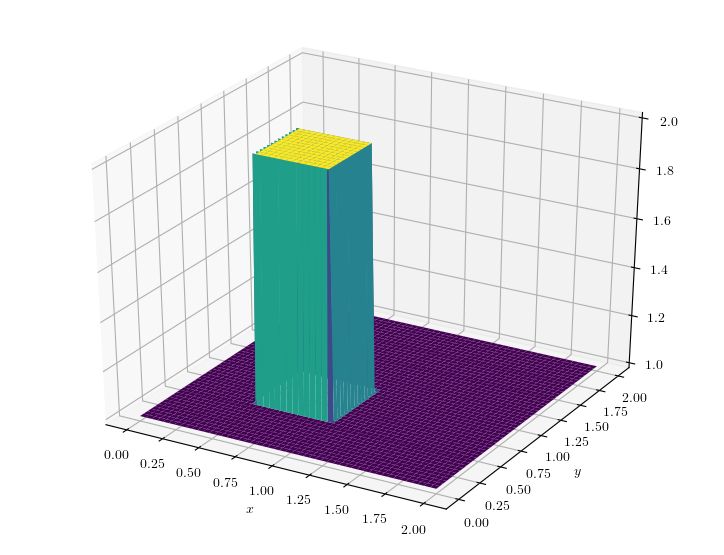

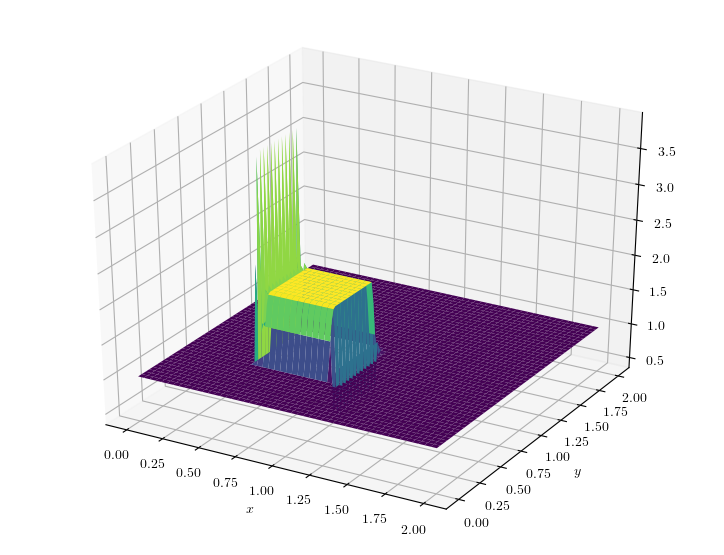

In [660]:
def convection2D(mesh_size_x, mesh_size_y, time):
    c = 1
    dx = 2.0/(mesh_size_x-1)
    dy = 2.0/(mesh_size_y-1)
    sigma = 0.2
    dt = sigma*min(dx,dy)
    timesteps = int(time/dt)
    
    x = numpy.linspace(0, 2, mesh_size_x)
    y = numpy.linspace(0, 2, mesh_size_y)

    u = numpy.ones((timesteps, mesh_size_x, mesh_size_y))
    v = numpy.ones((timesteps, mesh_size_x, mesh_size_y))
    
    # Initial conditions
    u[0][int(.5/dx):int(1/dx + 1),int(.5/dy):int(1/dy+1)] = 2
    v[0][int(.5/dx):int(1/dx + 1),int(.5/dy):int(1/dy+1)] = 2
    
    # Boundary conditions
    u[1:][0,:] = 1
    u[1:][-1,:] = 1
    u[1:][:,0] = 1
    u[1:][:,-1] = 1
    v[1:][0,:] = 1
    v[1:][-1,:] = 1
    v[1:][:,0] = 1
    v[1:][:,-1] = 1
    
    for n in range(timesteps-1):
        u[n+1][1:, 1:] = u[n][1:, 1:] - c*dt*(u[n][1:, 1:]*(u[n][1:, 1:] - u[n][:-1, 1:])/dx - v[n][1:, 1:]*(u[n][1:, 1:] - u[n][1:, :-1])/dy)
        v[n+1][1:, 1:] = v[n][1:, 1:] - c*dt*(u[n][1:, 1:]*(v[n][1:, 1:] - v[n][:-1, 1:])/dx - v[n][1:, 1:]*(v[n][1:, 1:] - v[n][1:, :-1]/dy))

    return x, y, u, v
    
pos_x, pos_y, vel_x, vel_y = convection2D(101, 101, 0.02)

# Plotting
fig = pyplot.figure(1, figsize=(9, 7), dpi=100)
ax = fig.gca(projection='3d')
X, Y = numpy.meshgrid(pos_x, pos_y)
surf = ax.plot_surface(X, Y, vel_x[0], cmap=cm.viridis, rstride=2, cstride=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

fig = pyplot.figure(2, figsize=(9, 7), dpi=100)
ax = fig.gca(projection='3d')
X, Y = numpy.meshgrid(pos_x, pos_y)
surf2 = ax.plot_surface(X, Y, vel_x[-1], cmap=cm.viridis, rstride=2, cstride=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
pyplot.show()

### **Step 7: 2-D Diffusion**

#### Professor

Partial differential equation: $$ \frac{\partial u}{\partial t} = \nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) $$

Discretised: $$ \frac{u^{n+1}_i - u^n_i}{\Delta t} = \nu\left[\frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{(\Delta x)^2} + \frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{(\Delta y)^2}\right] $$

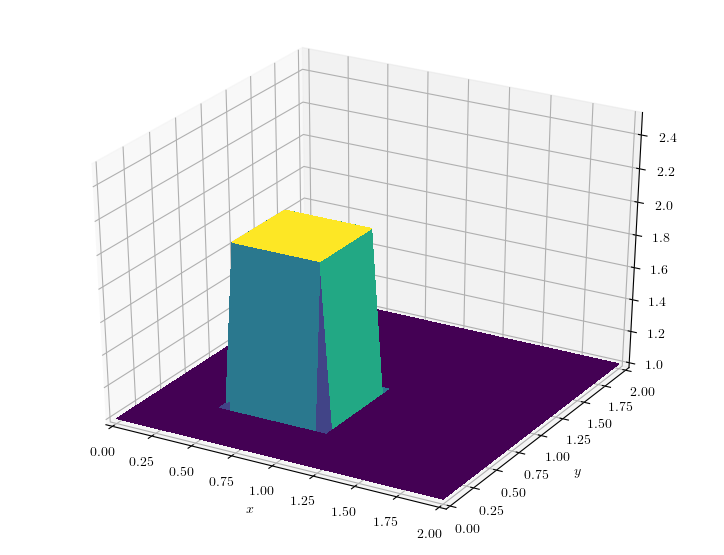

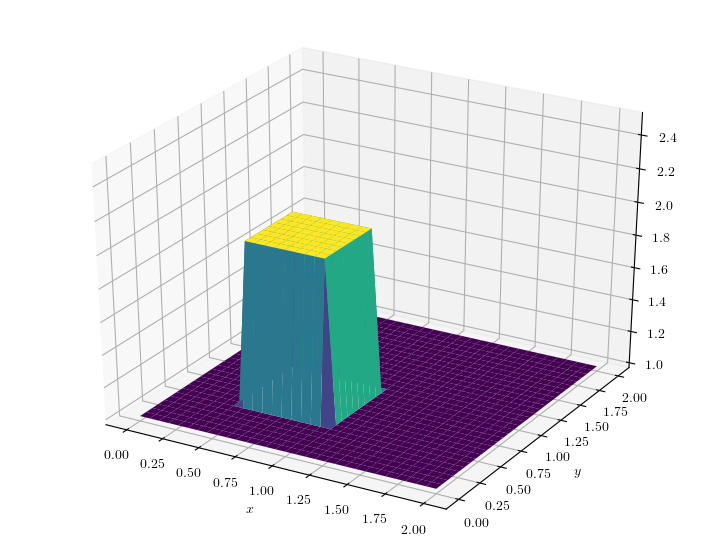

In [680]:
nx = 31
ny = 31
nt = 17
nu = .05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .25
dt = sigma*dt*dy/nu

x = numpy.linspace(0,2,nx)
y = numpy.linspace(0,2,ny)

u = numpy.ones((ny,nx))
un = numpy.ones((ny,nx))

u[int(.5/dy):int(1/dy+1),int(.5/dx):int(1/dx+1)] = 2

fig = pyplot.figure(figsize=(9,7), dpi = 100)
ax = fig.gca(projection='3d')
X, Y = numpy.meshgrid(x, y)
surf = ax.plot_surface(X, Y, u, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_zlim(1, 2.5)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

def diffuse(nt):
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2  # Why is this repeated?
    
    for n in range(nt+1):
        un = u.copy()
        u[1:-1,1:-1] = un[1:-1,1:-1] + nu*dt*((un[1:-1,2:] - 2*un[1:-1,1:-1] + un[1:-1,0:-2])/dy**2 + (un[2:,1:-1] - 2*un[1:-1,1:-1] + un[0:-2,1:-1])/dx**2)
        u[0,:] = 1
        u[-1,:] = 1
        u[:,0] = 1
        u[:,-1] = 1
    
    fig2 = pyplot.figure(figsize=(9,7), dpi = 100)
    ax = fig2.gca(projection='3d')
    surf2 = ax.plot_surface(X, Y, u[:], rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=True)
    ax.set_zlim(1, 2.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    
diffuse(50)